# 전이학습 기반 폐렴 진단 보조 모델 개발 및 시각적 해석

## 1. 라이브러리 Import 및 디바이스 설정

In [ ]:
# 표준 라이브러리
import os
import math
import random
from pathlib import Path
import csv
import sys

# 수치 연산 / 데이터 처리
import numpy as np
import pandas as pd

# 이미지 처리
import cv2
from PIL import Image

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


# 머신러닝 / 통계
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

# PyTorch & TorchVision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

# 기타 유틸
from tqdm import tqdm
from pathlib import Path

# 버전 출력
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")

PyTorch: 2.9.1
NumPy: 1.26.4


In [3]:
def get_device():
    """
    사용 가능한 연산 장치를 자동으로 탐지하여 반환하는 함수.

    동작 우선순위:
    1. CUDA GPU가 존재하면 'cuda' 장치를 반환
    2. (Mac 전용) Apple Silicon MPS 가속기가 가능하면 'mps' 장치를 반환
    3. 위 두 옵션이 모두 없을 경우 CPU 장치를 반환

    Returns:
        torch.device: 선택된 연산 장치 (cuda / mps / cpu)
    """
    # 1) CUDA (Colab or PC)
    # (코랩 설정 필요: 메뉴 - 런타임 - 런타임 유형 변경 - 하드웨어 가속기)
    if torch.cuda.is_available():
        print("CUDA GPU detected.")
        return torch.device("cuda")

    # 2) Apple Silicon (Local Mac)
    if torch.backends.mps.is_available():
        print("Apple MPS GPU detected.")
        return torch.device("mps")

    # 3) CPU fallback
    print("No GPU detected. Using CPU.")
    return torch.device("cpu")


device = get_device()
print(f"Using device: {device}")

Apple MPS GPU detected.
Using device: mps


## 2. 데이터 셋 다운로드 및 경로 설정

이 섹션에서는 Kaggle의 Chest X-Ray Pneumonia 데이터셋을 다운로드하고,
`train / val / test` 디렉토리 경로를 변수로 설정합니다.

- 데이터 출처: Kaggle – *Chest X-Ray Images (Pneumonia)*
- 사용 라이브러리: `kagglehub`
- 출력: 학습/검증/테스트용 이미지 디렉토리 경로(`train_dir`, `val_dir`, `test_dir`)

In [4]:
import kagglehub

# Kaggle Chest X-Ray Pneumonia 데이터셋 다운로드
dataset_root = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset root:", dataset_root)

# Path 객체로 변환
dataset_root = Path(dataset_root) / "chest_xray"

# train / val / test 디렉토리 경로 설정
train_dir = dataset_root / "train"
val_dir   = dataset_root / "val"
test_dir  = dataset_root / "test"

print("train_dir:", train_dir)
print("val_dir:", val_dir)
print("test_dir:", test_dir)

/opt/anaconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset root: /Users/youuchul/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
train_dir: /Users/youuchul/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
val_dir: /Users/youuchul/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
test_dir: /Users/youuchul/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test


## 3. 전처리 및 증강

In [5]:
data_transforms = {
    "train": v2.Compose([
        v2.ToImage(),                         # PIL → 이미지 tensor (C,H,W)
        v2.Resize((256, 256)),                # 약간 크게 리사이즈
        # 의료 데이터 : 증강 지양해야 하기에 최소한으로 작업
        v2.RandomCrop((224, 224)),            # 224x224로 랜덤 크롭
        v2.RandomRotation(20),                # -20 ~ +20도 범위 회전
        v2.ToDtype(torch.float32, scale=True),# 0~1 float32
        v2.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
        ),
    ]),
    "val": v2.Compose([
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
        ),
    ]),
    "test": v2.Compose([
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
        ),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms["val"])
test_dataset  = datasets.ImageFolder(test_dir,  transform=data_transforms["test"])

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

class_names = train_dataset.classes

- Train: 모델 일반화를 위해 회전/크롭 기반 Augmentation 적용
- Val/Test: 데이터 분포를 보존하기 위해 Resize + Normalize만 적용

## 4. 샘플 시각화 및 데이터 탐색

In [6]:
def denorm(img):
    """정규화된 이미지를 [0,1] 범위로 되돌림. img: Tensor [C,H,W] 또는 [B,C,H,W]"""
    mean = torch.tensor([0.5, 0.5, 0.5], device=img.device, dtype=img.dtype).view(1, 3, 1, 1)
    std  = torch.tensor([0.5, 0.5, 0.5], device=img.device, dtype=img.dtype).view(1, 3, 1, 1)

    if img.ndim == 3:   # [C,H,W] → [1,C,H,W]로 맞춰서 브로드캐스트
        img = img.unsqueeze(0)

    img = img * std + mean
    img = torch.clamp(img, 0, 1)

    if img.shape[0] == 1:
        img = img.squeeze(0)

    return img

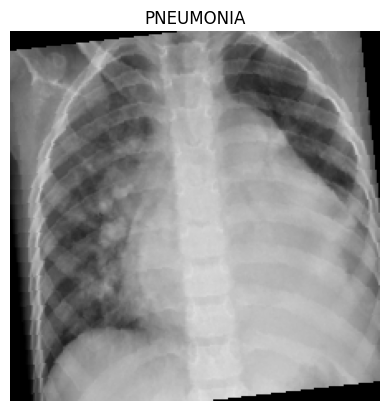

In [12]:
# 배치에서 이미지 하나 뽑아 시각화 (train데이터 로더에서)
images, labels = next(iter(train_loader))

def imshow(img, title=None):
    """Normalize 해제 후 이미지 하나를 시각화하는 함수."""
    img = denorm(img).cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

idx = 5 # 확인할 이미지
imshow(
    images[idx],
    title=class_names[labels[idx].item()]
)

- train 예정 데이터 문제 없음, 확인

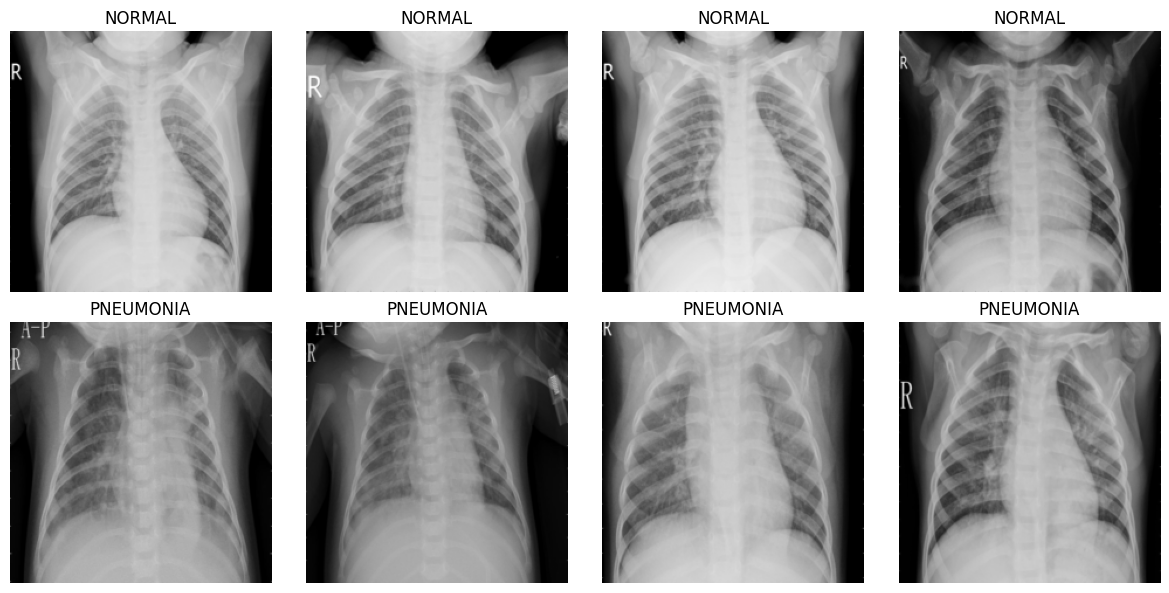

In [13]:
# NORMAL / PNEUMONIA 비교용 샘플 이미지 4장씩 수집
normal_imgs = []
pneum_imgs = []

# 이미지 비교를 위해 증강이 없는 validation 데이터 가져옴
for imgs, labs in val_loader:
    for img, lab in zip(imgs, labs):
        if lab.item() == 0 and len(normal_imgs) < 4:   # NORMAL
            normal_imgs.append(img)
        elif lab.item() == 1 and len(pneum_imgs) < 4:  # PNEUMONIA
            pneum_imgs.append(img)

    # 필요한 수만큼 모였다면 반복 종료
    if len(normal_imgs) >= 4 and len(pneum_imgs) >= 4:
        break

# 8개 이미지(각 4장) + 레이블
all_imgs = normal_imgs + pneum_imgs
all_labels = [0]*4 + [1]*4

# 시각화
plt.figure(figsize=(12, 6))
for i, (img, lab) in enumerate(zip(all_imgs, all_labels)):
    ax = plt.subplot(2, 4, i+1)
    img = denorm(img).cpu()  # 정규화 해제 함수 활용
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # ← cmap 제거
    plt.title(class_names[lab])
    plt.axis("off")

plt.tight_layout()
plt.show()

시각화 비교 EDA 위한 X-ray 이미지 개념
- X-ray 영상의 밝기 : X-ray 투과 정도
- 어둡게 보인다 = X-ray가 잘 통과했다 (공기가 많다 = 정상 폐 / 단, 기흉은 더 검게 보임)
- 밝게 보인다 = X-ray가 통과하지 못 함 (물, 염증 등이 많다 = 비정상 가능성이 크다 / 심장, 뼈 는 하얗게 보임)

> 변화를 더 뚜렷하게 비교하기 위해 추가 시각화 진행

NORMAL val samples: 8
PNEUMONIA val samples: 8


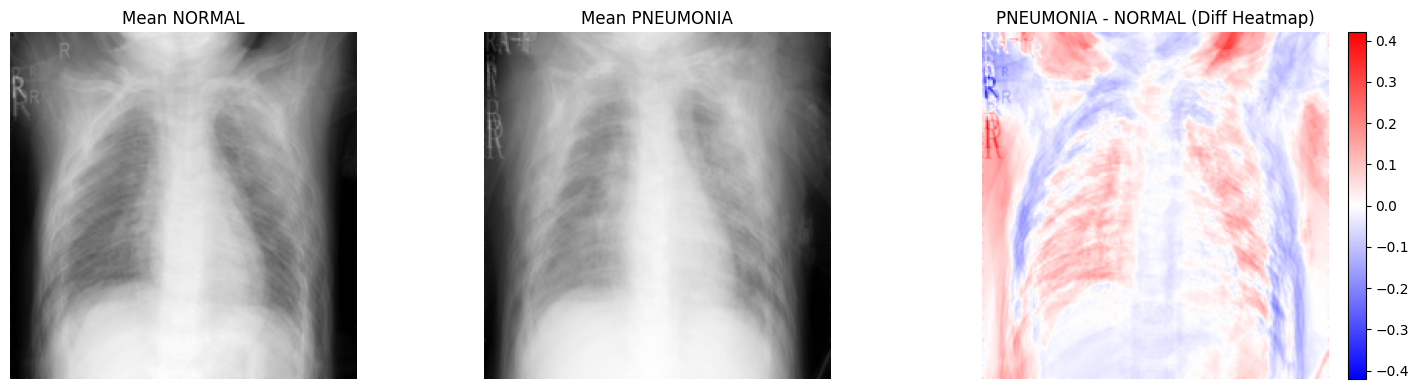

In [7]:
# 1) Val 데이터에서 NORMAL / PNEUMONIA 파일 경로 수집
# ImageFolder는 .samples에 (파일경로, 라벨) 리스트를 들고 있음
# 라벨: NORMAL=0, PNEUMONIA=1 (class_names 기준)
normal_paths = [path for path, label in val_dataset.samples if label == 0]
pneum_paths  = [path for path, label in val_dataset.samples if label == 1]

print(f"NORMAL val samples: {len(normal_paths)}")
print(f"PNEUMONIA val samples: {len(pneum_paths)}")

# 한 클래스당 사용할 샘플 수 (너무 크면 느려지므로 적당히)
num_samples_per_class = 200

normal_sel = random.sample(
    normal_paths,
    k=min(num_samples_per_class, len(normal_paths))
)
pneum_sel = random.sample(
    pneum_paths,
    k=min(num_samples_per_class, len(pneum_paths))
)

# 2) 공통 유틸: X-Ray 파일을 회색조 + 동일 크기(224x224)로 로드
def load_xray_gray(path, size=(224, 224)):
    """
    흉부 X-Ray 이미지를 회색조(grayscale)로 불러와
    [0,1] 범위 float32 2D 배열(H,W)로 반환.
    """
    img = Image.open(path).convert("L")  # L: grayscale
    img = img.resize(size)               # 모델 입력 크기와 맞춤
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 3) NORMAL / PNEUMONIA 각각 평균 이미지 계산
# [N,H,W] → axis=0 평균 → [H,W]
normal_stack = np.stack([load_xray_gray(p) for p in normal_sel], axis=0)
pneum_stack  = np.stack([load_xray_gray(p) for p in pneum_sel], axis=0)

mean_normal = normal_stack.mean(axis=0)
mean_pneum  = pneum_stack.mean(axis=0)

# 차이: PNEUMONIA - NORMAL (양수일수록 폐렴에서 더 밝아진 부분)
diff = mean_pneum - mean_normal

# diff 히트맵 스케일 맞추기 (양/음 대칭 범위)
max_abs = np.max(np.abs(diff))

# 4) 시각화
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Mean NORMAL")
plt.imshow(mean_normal, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mean PNEUMONIA")
plt.imshow(mean_pneum, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("PNEUMONIA - NORMAL (Diff Heatmap)")
plt.imshow(diff, cmap="bwr", vmin=-max_abs, vmax=max_abs)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.tight_layout()
plt.show()

1) Mean NORMAL
- 폐야 배부에 공기가 균일하게 잘 차있어, 평균 이미지의 폐가 뚜렷하고 검게 보임

2) Mean PNEUMONIA
- 전체적으로 윤곽이 정상 폐보다 훨씬 흐릿함
- 공기가 채워져 있어야 할 부분에 물/염증/침윤 등이 차서, X-ray 통과량이 줄어들어 밝게 보임
- 개별 환자마다 병변 위치는 다르지만, 폐 전체가 밝게 퍼지는 경향이 평균 이미지에 반영됨

3) Diff (mean_pneum - mean_normal)
- 빨강(diff > 0) → 폐렴(PNEUMONIA)의 픽셀값이 더 큼 → 폐렴이 더 밝다   
폐렴에서 밝기가 증가한 부위 → 염증·침윤으로 인한 음영 증가 패턴

- 파랑(diff < 0) → 정상(NORMAL)의 픽셀값이 더 큼 → 정상 쪽이 더 밝다   
NORMAL 영상이 더 밝게 나타난 부분으로, 대개 늑골·흉곽과 같은 해부학적 외곽 구조의 대비 차이로 인해 발생하며 병리적 의미는 크지 않음

- 따라서 Diff Heatmap은 폐렴 특징이 평균 수준에서도 분명하게 나타나며, 모델이 주목할 가능성이 큰 부위(폐 하부·중앙부)를 파악



> **시각화 진단 비교**
> - NORMAL: 폐야가 전체적으로 어둡고 선명하며, 폐혈관·늑골 등의 구조가 명확
> - PNEUMONIA: 폐렴으로 인해 폐 내부가 뿌옇고 밝아지며, 혈관 구조가 흐려지고 전체적인 대비가 감소. 또한 좌우 폐의 대칭성이 흔히 깨짐

## 5. 모델 정의 : 비교용 기본 CNN과 전이학습 모델

### 5.1 Baseline CNN (from scratch)



In [8]:
num_classes = len(class_names)
print("num_classes:", num_classes)  # 보통 2 (NORMAL / PNEUMONIA)

class SimpleCNN(nn.Module):
    """
    비교용 기본 CNN 분류기.
    - 3개의 Conv-BN-ReLU-MaxPool 블록
    - Global Average Pooling 후 FC로 이진 분류
    - from scratch 학습용 (사전학습 가중치 사용 X)
    """
    def __init__(self, num_classes: int):
        super().__init__()

        # 입력: [B, 3, H, W]
        # conv1: 채널 3 → 32, 특성맵 크기 1/2
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # H,W -> H/2, W/2
        )

        # conv2: 32 → 64, 특성맵 크기 1/4
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # H,W -> H/4, W/4
        )

        # conv3: 64 → 128, 특성맵 크기 1/8
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # H,W -> H/8, W/8
        )

        # Global Average Pooling : [B,128,H/8,W/8] → [B,128,1,1]
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # 최종 분류기: [B,128] → [B,num_classes]
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)              # [B,32,H/2,W/2]
        x = self.conv2(x)              # [B,64,H/4,W/4]
        x = self.conv3(x)              # [B,128,H/8,W/8]
        x = self.gap(x)                # [B,128,1,1]
        x = torch.flatten(x, 1)        # [B,128]
        x = self.fc(x)                 # [B,num_classes]
        return x

baseline_model = SimpleCNN(num_classes).to(device)
baseline_model

num_classes: 2


SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, 

In [9]:
import logging

def init_logger():
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] (%(filename)s:%(lineno)d) - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        force=True,                 # ← Jupyter에서 강제 재설정
    )
    return logging.getLogger("pneumonia")

logger = init_logger()
logger.info("Logger initialized")

2025-11-25 01:39:11 [INFO] (2436937078.py:16) - Logger initialized


In [10]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, logger=None):
    """
    한 에폭(epoch) 동안 모델을 학습시키는 함수.

    Args:
        model (nn.Module):
            학습할 PyTorch 모델.
        dataloader (DataLoader):
            학습 데이터 로더 (train_loader).
        criterion (nn.Module):
            손실 함수 (예: CrossEntropyLoss).
        optimizer (torch.optim.Optimizer):
            모델 파라미터를 업데이트할 옵티마이저.
        device (torch.device):
            CPU, CUDA 또는 MPS 디바이스.
        logger (logging.Logger, optional):
            학습 진행 상황을 기록할 로거. 기본은 None.

    Returns:
        tuple:
            - epoch_loss (float): 해당 epoch의 평균 loss.
            - epoch_acc (float): 해당 epoch의 평균 accuracy.

    Notes:
        - 모델을 train 모드로 전환한다.
        - forward → loss 계산 → backward → optimizer.step 의 학습 단계를 진행한다.
        - running_loss와 running_corrects는 미니배치 단위로 누적.
        - tqdm을 사용해 진행률을 표시한다.
        - logger가 존재하면 각 epoch 시작/종료 정보를 기록한다.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    if logger:
        logger.info("Training epoch start")

    for inputs, labels in tqdm(dataloader, leave=False, desc="Train"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total

    if logger:
        logger.info(f"TRAIN — loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}")

    return epoch_loss, epoch_acc

In [11]:
def eval_one_epoch(model, dataloader, criterion, device, logger=None):
    """
    한 에폭(epoch) 동안 모델을 평가하는 함수 (검증/테스트용).

    Args:
        model (nn.Module):
            평가할 PyTorch 모델.
        dataloader (DataLoader):
            검증 또는 테스트용 데이터 로더.
        criterion (nn.Module):
            손실 함수 (예: CrossEntropyLoss).
        device (torch.device):
            CPU, CUDA 또는 MPS 디바이스.
        logger (logging.Logger, optional):
            평가 진행 상황을 기록할 로거. 기본은 None.

    Returns:
        tuple:
            - epoch_loss (float): 해당 epoch의 평균 loss.
            - epoch_acc (float): 해당 epoch의 평균 accuracy.

    Notes:
        - 모델을 eval 모드로 전환한다.
        - torch.no_grad() 내부에서 수행하므로 gradient 계산 없음.
        - optimizer는 사용되지 않으며, 순전파(forward)와 손실 계산만 수행.
        - running_loss와 running_corrects는 미니배치 단위로 누적.
        - logger가 존재하면 평가 시작/종료 정보를 기록한다.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    if logger:
        logger.info("Validation epoch start")

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False, desc="Eval"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
            total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total

    if logger:
        logger.info(f"EVAL — loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}")

    return epoch_loss, epoch_acc

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)

logger.info("=== Baseline SimpleCNN DRY-RUN (1 epoch test) ===")

train_loss, train_acc = train_one_epoch(
    baseline_model,
    train_loader,
    criterion,
    optimizer,
    device,
    logger=logger,
)

val_loss, val_acc = eval_one_epoch(
    baseline_model,
    val_loader,
    criterion,
    device,
    logger=logger,
)

logger.info(f"[DRY RUN RESULT] Train acc={train_acc:.4f}, Val acc={val_acc:.4f}")

2025-11-24 22:16:26 [INFO] (4094823702.py:4) - === Baseline SimpleCNN DRY-RUN (1 epoch test) ===
2025-11-24 22:16:26 [INFO] (4278254002.py:37) - Training epoch start
2025-11-24 22:18:24 [INFO] (4278254002.py:61) - TRAIN — loss: 0.3632, acc: 0.8275
2025-11-24 22:18:24 [INFO] (2331345497.py:35) - Validation epoch start
2025-11-24 22:18:25 [INFO] (2331345497.py:55) - EVAL — loss: 1.8837, acc: 0.5000
2025-11-24 22:18:25 [INFO] (4094823702.py:23) - [DRY RUN RESULT] Train acc=0.8275, Val acc=0.5000


### 5.2 ResNet18 기반 전이학습 / 파인튜닝 모델
- mode="frozen"
- mode="partial"
- mode="full"\

In [12]:
def create_resnet18(num_classes: int, mode: str = "frozen"):
    """
    ResNet18 기반 전이학습/파인튜닝 모델 생성 함수.

    Args:
        num_classes (int): 분류 클래스 개수.
        mode (str): 파인튜닝 전략 선택.
            - "frozen"  : backbone 전체 동결, fc만 학습
            - "partial" : layer4 + fc만 학습
            - "full"    : 전체 미세조정 (fine-tuning)

    Returns:
        torch.nn.Module: 학습 가능한 파라미터가 지정된 ResNet18 모델
    """

    # 1. Pretrained ResNet18 불러오기
    try:
        # 최신 torchvision (weights 방식)
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
    except AttributeError:
        # 구버전 torchvision (pretrained=True)
        model = models.resnet18(pretrained=True)

    # 2. FC 레이어 교체 (클래스 수에 맞춤)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # 3. mode에 따라 requires_grad 설정
    if mode == "frozen":
        # 전체 동결 → FC만 학습
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    elif mode == "partial":
        # 전체 동결 후, layer4 + fc만 활성화
        for param in model.parameters():
            param.requires_grad = False

        for name, param in model.named_parameters():
            if name.startswith("layer4") or name.startswith("fc"):
                param.requires_grad = True

    elif mode == "full":
        # 전체 파라미터 fine-tuning
        for param in model.parameters():
            param.requires_grad = True

    else:
        raise ValueError("mode must be one of ['frozen', 'partial', 'full']")

    return model.to(device)

In [13]:
resnet_frozen = create_resnet18(num_classes, mode="frozen")
resnet_partial = create_resnet18(num_classes, mode="partial")
resnet_full    = create_resnet18(num_classes, mode="full")

- 모델 분류, 지정

In [14]:
def make_optimizer(model, lr=1e-4):
    return optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )

- 전이학습 모델에서는 requires_grad=True 인 파라미터만 optimizer에 넣어야 함

In [23]:
# 1에폭씩 테스트
# resnet_frozen
logger.info("=== Frozen ResNet18 DRY-RUN (1 epoch) ===")
criterion = nn.CrossEntropyLoss()

optimizer_frozen = make_optimizer(resnet_frozen, lr=1e-4)

train_loss, train_acc = train_one_epoch(
    resnet_frozen, train_loader, criterion, optimizer_frozen, device, logger=logger
)

val_loss, val_acc = eval_one_epoch(
    resnet_frozen, val_loader, criterion, device, logger=logger
)

logger.info(f"[Frozen] Train acc={train_acc:.4f}, Val acc={val_acc:.4f}")

# resnet_partial
logger.info("=== Partial ResNet18 DRY-RUN (1 epoch) ===")
optimizer_partial = make_optimizer(resnet_partial, lr=1e-4)

train_loss, train_acc = train_one_epoch(
    resnet_partial, train_loader, criterion, optimizer_partial, device, logger=logger
)
val_loss, val_acc = eval_one_epoch(
    resnet_partial, val_loader, criterion, device, logger=logger
)

logger.info(f"[Partial] Train acc={train_acc:.4f}, Val acc={val_acc:.4f}")

# resnet_full
logger.info("=== Full ResNet18 DRY-RUN (1 epoch) ===")
optimizer_full = make_optimizer(resnet_full, lr=1e-4)

train_loss, train_acc = train_one_epoch(
    resnet_full, train_loader, criterion, optimizer_full, device, logger=logger
)
val_loss, val_acc = eval_one_epoch(
    resnet_full, val_loader, criterion, device, logger=logger
)

logger.info(f"[Full] Train acc={train_acc:.4f}, Val acc={val_acc:.4f}")

2025-11-24 22:18:43 [INFO] (1798406321.py:3) - === Frozen ResNet18 DRY-RUN (1 epoch) ===
2025-11-24 22:18:43 [INFO] (4278254002.py:37) - Training epoch start
2025-11-24 22:20:23 [INFO] (4278254002.py:61) - TRAIN — loss: 0.5197, acc: 0.7525
2025-11-24 22:20:23 [INFO] (2331345497.py:35) - Validation epoch start
2025-11-24 22:20:24 [INFO] (2331345497.py:55) - EVAL — loss: 0.5509, acc: 0.5625
2025-11-24 22:20:24 [INFO] (1798406321.py:16) - [Frozen] Train acc=0.7525, Val acc=0.5625
2025-11-24 22:20:24 [INFO] (1798406321.py:19) - === Partial ResNet18 DRY-RUN (1 epoch) ===
2025-11-24 22:20:24 [INFO] (4278254002.py:37) - Training epoch start
2025-11-24 22:22:04 [INFO] (4278254002.py:61) - TRAIN — loss: 0.1493, acc: 0.9379
2025-11-24 22:22:04 [INFO] (2331345497.py:35) - Validation epoch start
2025-11-24 22:22:04 [INFO] (2331345497.py:55) - EVAL — loss: 0.2960, acc: 0.8125
2025-11-24 22:22:04 [INFO] (1798406321.py:29) - [Partial] Train acc=0.9379, Val acc=0.8125
2025-11-24 22:22:04 [INFO] (17984

### 5.3 학습 및 성능 비교/평가

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs: int = 10,
    logger=None,
    model_name: str | None = None,
    save_dir: str = "checkpoints", # 구글 드라이브 저장 시 경로 수정, 예: ("/content/drive/MyDrive/projectname_checkpoints")
    resume: bool = False          # 이어학습 여부 추가
):
    """
    모델 학습 + 검증을 수행하고 history를 반환하는 함수.
    - 매 epoch마다 train/val loss, acc 기록
    - model_name이 주어지면, best val_acc 기준으로 모델 가중치 저장

    Args:
        model: 학습할 PyTorch 모델
        train_loader: 학습용 DataLoader
        val_loader: 검증용 DataLoader
        criterion: 손실 함수 (예: CrossEntropyLoss)
        optimizer: 옵티마이저 (예: Adam)
        device: torch.device (cpu / cuda / mps)
        epochs: 전체 학습 epoch 수
        logger: logging.Logger (옵션)
        model_name: 저장할 모델 이름 (예: "baseline_simplecnn")
        save_dir: 체크포인트 저장 디렉토리
        resume=True 를 사용하면 자동으로 `{model_name}_last.pth`에서 이어 학습합니다.

    Returns:
        history (dict):
            {
                "train_loss": [...],
                "train_acc": [...],
                "val_loss": [...],
                "val_acc": [...],
            }
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    # -----------------------------
    # 1) 체크포인트 기본 설정
    # -----------------------------
    os.makedirs(save_dir, exist_ok=True)
    best_val_acc = -1.0
    start_epoch = 1

    ckpt_path = os.path.join(save_dir, f"{model_name}_last.pth") if model_name else None

    # -----------------------------
    # 2) 이어학습(resume) 처리
    # -----------------------------
    if resume and model_name and os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=device)

        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        best_val_acc = checkpoint["best_val_acc"]
        start_epoch = checkpoint["epoch"] + 1

        if logger:
            logger.info(
                f"[RESUME] {model_name} 이어학습 시작 — epoch {start_epoch}부터 진행"
            )

    # -----------------------------
    # 3) 학습 루프 시작
    # -----------------------------
    for epoch in range(start_epoch, epochs + 1):

        if logger:
            logger.info(f"===== Epoch {epoch}/{epochs} =====")

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, logger=logger)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device, logger=logger)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # -----------------------------
        # 4) Best 체크포인트 저장
        # -----------------------------
        if model_name and val_acc > best_val_acc:
            best_val_acc = val_acc
            best_path = os.path.join(save_dir, f"{model_name}_best.pth")
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_acc": best_val_acc,
            }, best_path)

            if logger:
                logger.info(
                    f"[BEST UPDATED] {model_name}: val_acc={val_acc:.4f} → saved to {best_path}"
                )

        # -----------------------------
        # 5) Last 체크포인트 저장 (항상 저장)
        # -----------------------------
        if model_name:
            last_path = os.path.join(save_dir, f"{model_name}_last.pth")
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_acc": best_val_acc,
            }, last_path)

            if logger:
                logger.info(f"[LAST MODEL SAVED] {model_name}: epoch={epoch}")

    return history

In [16]:
criterion = nn.CrossEntropyLoss()

optim_baseline = make_optimizer(baseline_model, lr=1e-3)
optim_frozen   = make_optimizer(resnet_frozen, lr=1e-4)
optim_partial  = make_optimizer(resnet_partial, lr=1e-4)
optim_full     = make_optimizer(resnet_full, lr=1e-5)

In [20]:
epochs = 10

history_baseline = fit(
    baseline_model,
    train_loader,
    val_loader,
    criterion,
    optim_baseline,
    device,
    epochs,
    logger=logger,
    model_name="baseline_simplecnn",
    save_dir="./x_ray_checkpoints",
    resume=False
)

history_frozen = fit(
    resnet_frozen,
    train_loader,
    val_loader,
    criterion,
    optim_frozen,
    device,
    epochs,
    logger=logger,
    model_name="resnet18_frozen",
    save_dir="./x_ray_checkpoints",
    resume=False
)

history_partial = fit(
    resnet_partial,
    train_loader,
    val_loader,
    criterion,
    optim_partial,
    device,
    epochs,
    logger=logger,
    model_name="resnet18_partial",
    save_dir="./x_ray_checkpoints",
    resume=False
)

history_full = fit(
    resnet_full,
    train_loader,
    val_loader,
    criterion,
    optim_full,
    device,
    epochs,
    logger=logger,
    model_name="resnet18_full",
    save_dir="./x_ray_checkpoints",
    resume=False
)


2025-11-25 01:41:33 [INFO] (2325590284.py:79) - ===== Epoch 1/10 =====
2025-11-25 01:41:33 [INFO] (4278254002.py:37) - Training epoch start
2025-11-25 01:43:39 [INFO] (4278254002.py:61) - TRAIN — loss: 0.3268, acc: 0.8495
2025-11-25 01:43:39 [INFO] (2331345497.py:35) - Validation epoch start
2025-11-25 01:43:39 [INFO] (2331345497.py:55) - EVAL — loss: 1.1247, acc: 0.5625
2025-11-25 01:43:39 [INFO] (2325590284.py:103) - [BEST UPDATED] baseline_simplecnn: val_acc=0.5625 → saved to ./x_ray_checkpoints/baseline_simplecnn_best.pth
2025-11-25 01:43:39 [INFO] (2325590284.py:120) - [LAST MODEL SAVED] baseline_simplecnn: epoch=1
2025-11-25 01:43:39 [INFO] (2325590284.py:79) - ===== Epoch 2/10 =====
2025-11-25 01:43:39 [INFO] (4278254002.py:37) - Training epoch start
2025-11-25 01:45:29 [INFO] (4278254002.py:61) - TRAIN — loss: 0.2652, acc: 0.8861
2025-11-25 01:45:29 [INFO] (2331345497.py:35) - Validation epoch start
2025-11-25 01:45:29 [INFO] (2331345497.py:55) - EVAL — loss: 1.9730, acc: 0.500

In [22]:
histories = {
    "Baseline SimpleCNN": history_baseline,
    "ResNet18 Frozen": history_frozen,
    "ResNet18 Partial": history_partial,
    "ResNet18 Full": history_full,
}


def plot_train_loss_only(histories):
    """모델별 Train Loss만 비교하는 라인 차트"""
    fig = go.Figure()

    for name, h in histories.items():
        epochs = list(range(1, len(h["train_loss"]) + 1))

        fig.add_trace(
            go.Scatter(
                x=epochs,
                y=h["train_loss"],
                mode="lines+markers",
                name=name
            )
        )

    fig.update_layout(
        title="모델별 Train Loss 비교",
        xaxis_title="Epoch",
        yaxis_title="Train Loss",
        template="plotly_white",
    )
    fig.show()

def plot_val_loss_only(histories):
    """모델별 Val Loss만 비교하는 라인 차트"""
    fig = go.Figure()

    for name, h in histories.items():
        epochs = list(range(1, len(h["val_loss"]) + 1))

        fig.add_trace(
            go.Scatter(
                x=epochs,
                y=h["val_loss"],
                mode="lines+markers",
                name=name
            )
        )

    fig.update_layout(
        title="모델별 Val Loss 비교",
        xaxis_title="Epoch",
        yaxis_title="Validation Loss",
        template="plotly_white",
    )
    fig.show()


plot_train_loss_only(histories)
plot_val_loss_only(histories)

## 6. 모델 평가 및 해석

### 6.1 모델 별 평가 지표 비교

In [23]:
def evaluate_metrics(model, dataloader, device, logger=None):
    """
    주어진 모델에 대해 dataloader 전체에서 분류 성능을 계산.

    Args:
        model: 학습된 PyTorch 모델
        dataloader: 평가용 DataLoader (보통 test_loader)
        device: torch.device (cpu / cuda / mps)
        logger: logging.Logger (옵션)

    Returns:
        결과 dict:
        {
            "accuracy": float,
            "precision": float,
            "recall": float,
            "f1": float,
            "confusion_matrix": np.ndarray(2x2),
            "y_true": np.ndarray,
            "y_pred": np.ndarray,
        }
    """
    model.eval()
    all_preds = []
    all_labels = []

    if logger:
        logger.info("Start evaluation on dataloader")

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="binary"
    )
    cm = confusion_matrix(all_labels, all_preds)

    if logger:
        logger.info(
            f"Eval result - acc: {acc:.4f}, "
            f"precision: {prec:.4f}, recall: {rec:.4f}, f1: {f1:.4f}"
        )

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "y_true": all_labels,
        "y_pred": all_preds,
    }

In [24]:
# ============================================
# [A] 모델별 Test Set 평가
# ============================================
baseline_results = evaluate_metrics(baseline_model, test_loader, device, logger=logger)
res_frozen_results  = evaluate_metrics(resnet_frozen,  test_loader, device, logger=logger)
res_partial_results = evaluate_metrics(resnet_partial, test_loader, device, logger=logger)
res_full_results    = evaluate_metrics(resnet_full,    test_loader, device, logger=logger)


# ============================================
# [B] Summary Table 생성
# ============================================
summary_rows = []

results_list = [
    ("Baseline SimpleCNN", "-",          baseline_results),
    ("ResNet18",          "Frozen",      res_frozen_results),
    ("ResNet18",          "Partial FT",  res_partial_results),
    ("ResNet18",          "Full FT",     res_full_results),
]

for model_name, strategy, res in results_list:
    summary_rows.append({
        "model":    model_name,
        "strategy": strategy,
        "accuracy": res["accuracy"],
        "precision": res["precision"],
        "recall":    res["recall"],
        "f1":        res["f1"],
    })

summary_df = pd.DataFrame(summary_rows)


# ============================================
# [C] 포맷팅 & 출력
# ============================================
summary_df = summary_df.sort_values("f1", ascending=False)

summary_df.style.format({
    "accuracy": "{:.3f}",
    "precision": "{:.3f}",
    "recall": "{:.3f}",
    "f1": "{:.3f}",
}).set_caption("Test set classification metrics by model")

2025-11-25 09:01:25 [INFO] (3723731357.py:28) - Start evaluation on dataloader
2025-11-25 09:01:44 [INFO] (3723731357.py:51) - Eval result - acc: 0.8061, precision: 0.7969, recall: 0.9256, f1: 0.8565
2025-11-25 09:01:44 [INFO] (3723731357.py:28) - Start evaluation on dataloader
2025-11-25 09:02:21 [INFO] (3723731357.py:51) - Eval result - acc: 0.8301, precision: 0.7946, recall: 0.9821, f1: 0.8784
2025-11-25 09:02:21 [INFO] (3723731357.py:28) - Start evaluation on dataloader
2025-11-25 09:03:23 [INFO] (3723731357.py:51) - Eval result - acc: 0.9022, precision: 0.8782, recall: 0.9795, f1: 0.9261
2025-11-25 09:03:23 [INFO] (3723731357.py:28) - Start evaluation on dataloader
2025-11-25 09:04:05 [INFO] (3723731357.py:51) - Eval result - acc: 0.9135, precision: 0.8925, recall: 0.9795, f1: 0.9340


,model,strategy,accuracy,precision,recall,f1
3,ResNet18,Full FT,0.913,0.893,0.979,0.934
2,ResNet18,Partial FT,0.902,0.878,0.979,0.926
1,ResNet18,Frozen,0.830,0.795,0.982,0.878
0,Baseline SimpleCNN,-,0.806,0.797,0.926,0.856


1.	**Full Fine-tuning**은 네 모델 중 전반적으로 모든 지표에서 가장 우수한 모델로 판단
2.	**Partial Fine-tuning**은 Full파인튜닝 대비 근소하게 낮지만 역시 모든 지표가 안정적인 편
3.	**Frozen**은 Baseline보다 훨씬 우수하지만, fine-tuning 모델들 보다는 성능이 떨어짐.
4.	**Baseline CNN**은 전반적으로 성능이 크게 뒤처짐.

### 6.2 Grad-CAM을 활용, 우수 모델의 주목 영역 분석

모델이 이미지의 어떤 영역을 보고 예측을 수행했는지 시각적으로 이해하기 위해 Grad-CAM을 사용합니다.  
여기서는 `ResNet18 Full FT` 모델에 대해 시각화를 수행합니다.

In [29]:
# ResNet18 Full FT 모델의 최적 체크포인트 로드
# 학습 시 저장된 최적 모델 가중치를 불러옵니다.
model_name = "resnet18_full"
save_dir = "x_ray_checkpoints"
best_path = os.path.join(save_dir, f"{model_name}_best.pth")

# 모델 객체 초기화 (requires_grad=True 옵션으로)
# create_resnet18 함수는 num_classes와 mode를 인자로 받습니다.
# 여기서는 num_classes가 2이고 mode는 "full" 입니다.
full_ft_model_for_cam = create_resnet18(num_classes=num_classes, mode="full")

# 체크포인트 로드
if os.path.exists(best_path):
    checkpoint = torch.load(best_path, map_location=device)
    full_ft_model_for_cam.load_state_dict(checkpoint["model_state"])
    logger.info(f"[LOADED] {model_name} best model from {best_path}")
else:
    logger.error(f"[ERROR] Best model checkpoint not found at {best_path}")
    # 만약 체크포인트가 없다면 현재 학습된 모델을 사용하거나 에러 처리
    # 여기서는 예시를 위해 현재 메모리에 로드된 resnet_full 모델을 사용합니다.
    full_ft_model_for_cam = resnet_full
    logger.warning("Using current resnet_full in memory as no checkpoint was found.")

full_ft_model_for_cam.eval() # 모델을 평가 모드로 설정
logger.info("ResNet18 Full FT 모델 로드 및 평가 모드 설정 완료")

2025-11-25 09:26:35 [INFO] (1179133343.py:16) - [LOADED] resnet18_full best model from x_ray_checkpoints/resnet18_full_best.pth
2025-11-25 09:26:35 [INFO] (1179133343.py:25) - ResNet18 Full FT 모델 로드 및 평가 모드 설정 완료


In [34]:
def visualize_grad_cam(model, target_layer, input_tensor, target_category, class_names):
    """
    Grad-CAM을 사용하여 이미지와 히트맵을 시각화하는 함수.

    Args:
        model (nn.Module): Grad-CAM을 적용할 PyTorch 모델.
        target_layer (nn.Module): Grad-CAM을 계산할 모델의 특정 레이어.
        input_tensor (torch.Tensor): 전처리된 입력 이미지 텐서 (shape: [1, C, H, W]).
        target_category (int): 예측하려는 클래스 (예: 0 for NORMAL, 1 for PNEUMONIA).
        class_names (list): 클래스 이름 리스트.
    """
    # GradCAM 객체 초기화
    # `use_cuda=True`는 CUDA가 사용 가능할 때 GPU를 활용합니다. (최신 버전에서는 이 인자가 제거됨)
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Grad-CAM 타겟 설정
    # 특정 클래스에 대한 CAM을 생성하려면 ClassifierOutputTarget을 사용합니다.
    targets = [ClassifierOutputTarget(target_category)]

    # Grad-CAM 히트맵 계산
    # `aug_smooth=True`와 `eigen_smooth=True`는 시각적 품질을 개선할 수 있습니다.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)

    # 텐서를 [H, W, C] 형태로 변환하고 [0,1] 범위로 정규화하여 원본 이미지 준비
    # denorm 함수를 사용하여 원본 이미지의 픽셀 값을 복원합니다.
    rgb_img = denorm(input_tensor.cpu()).permute(1, 2, 0).numpy()

    # Grayscale CAM은 [1, H, W] 형태이므로 [H, W]로 변경합니다.
    grayscale_cam = grayscale_cam[0, :]

    # 원본 이미지 위에 Grad-CAM 히트맵을 오버레이합니다.
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # 결과 시각화
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Original ({class_names[target_category]})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM ({class_names[target_category]})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

logger.info("Grad-CAM 시각화 함수 정의 완료")


2025-11-25 09:40:50 [INFO] (3424628316.py:50) - Grad-CAM 시각화 함수 정의 완료


2025-11-25 09:42:36 [INFO] (2170506474.py:11) - Grad-CAM 타겟 레이어: BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
2025-11-25 09:42:43 [INFO] (2170506474.py:40) - 테스트 데이터에서 2개의 샘플 이미지 추출 완료.
2025-11-25 09:42:43 [INFO] (2170506474.py:47) - Grad-CAM 시각화 중: Class NORMAL


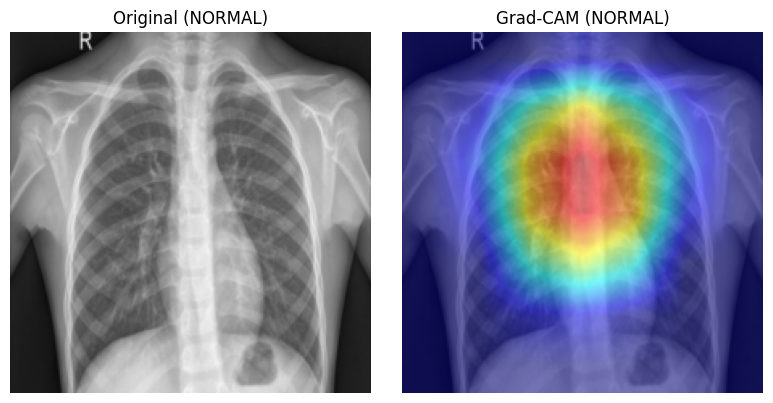

2025-11-25 09:42:54 [INFO] (2170506474.py:47) - Grad-CAM 시각화 중: Class PNEUMONIA


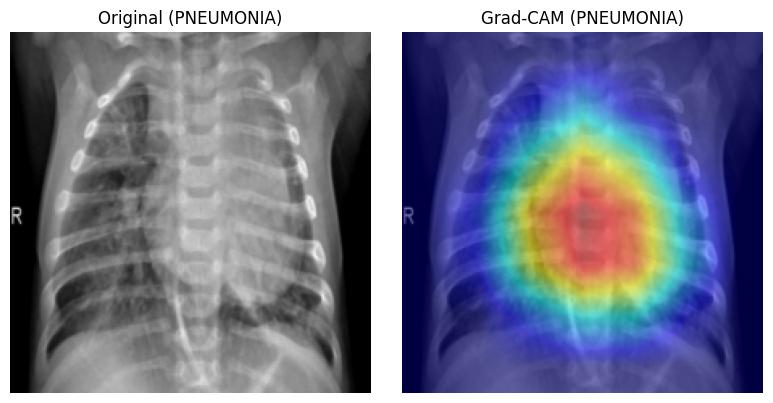

In [35]:

# ==================================================================
# Grad-CAM을 적용할 샘플 이미지 선택 및 시각화
# 테스트 데이터 로더에서 Normal과 Pneumonia 각각 1개씩 추출하여 시각화합니다.
# ==================================================================

# ResNet18의 마지막 컨볼루션 레이어를 타겟으로 설정합니다.
# 보통 ResNet18의 경우 `layer4`의 마지막 블록의 마지막 컨볼루션 레이어가 좋은 결과를 줍니다.
# `full_ft_model_for_cam.layer4[-1]`는 `layer4`의 마지막 기본 블록을 의미합니다.
# 그 안에서 `conv2`는 해당 블록의 두 번째 컨볼루션 레이어입니다.
target_layer = full_ft_model_for_cam.layer4[-1]
logger.info(f"Grad-CAM 타겟 레이어: {target_layer}")

# 테스트 데이터셋에서 이미지와 레이블 추출
sample_images = []
sample_labels = []

# 각 클래스별로 하나의 샘플을 찾기
found_normal = False
found_pneumonia = False

for inputs, labels in test_loader:
    for i in range(inputs.size(0)):
        if labels[i].item() == 0 and not found_normal:
            sample_images.append(inputs[i].unsqueeze(0).to(device)) # 배치 차원 추가
            sample_labels.append(labels[i].item())
            found_normal = True
        elif labels[i].item() == 1 and not found_pneumonia:
            sample_images.append(inputs[i].unsqueeze(0).to(device)) # 배치 차원 추가
            sample_labels.append(labels[i].item())
            found_pneumonia = True

        if found_normal and found_pneumonia:
            break
    if found_normal and found_pneumonia:
        break

if not sample_images:
    logger.error("테스트 데이터 로더에서 샘플 이미지를 찾을 수 없습니다.")
else:
    logger.info(f"테스트 데이터에서 {len(sample_images)}개의 샘플 이미지 추출 완료.")

    # 추출된 각 샘플에 대해 Grad-CAM 시각화 실행
    for i in range(len(sample_images)):
        input_tensor = sample_images[i]
        label = sample_labels[i]

        logger.info(f"Grad-CAM 시각화 중: Class {class_names[label]}")
        visualize_grad_cam(full_ft_model_for_cam, target_layer, input_tensor, label, class_names)

- 정상, 폐렴 모두 특정 한 곳보단 전반적인 형태를 파악하는 모습을 보임
- 폐렴은 추가 케이스를 더 살펴볼 필요가 있음

2025-11-25 09:43:30 [INFO] (712128529.py:8) - Grad-CAM 타겟 레이어: BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
2025-11-25 09:43:37 [INFO] (712128529.py:30) - PNEUMONIA 샘플 6개 추출 완료.
2025-11-25 09:43:37 [INFO] (712128529.py:34) - [1/6] Grad-CAM 시각화 중: Class PNEUMONIA


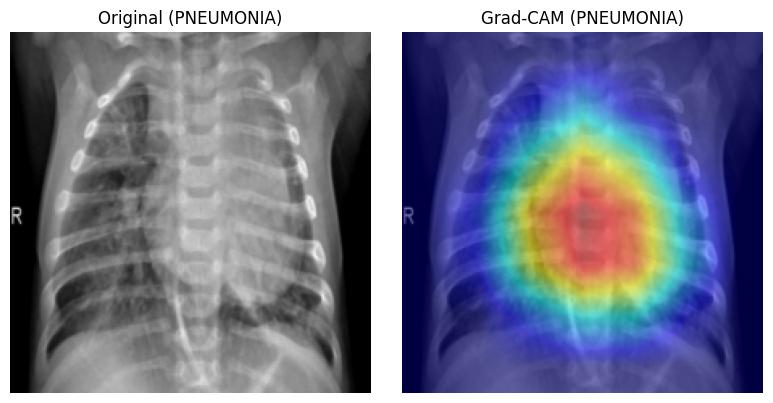

2025-11-25 09:43:44 [INFO] (712128529.py:34) - [2/6] Grad-CAM 시각화 중: Class PNEUMONIA


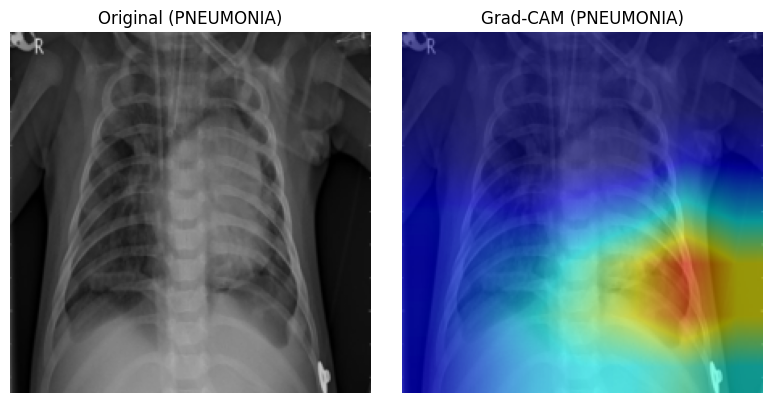

2025-11-25 09:43:47 [INFO] (712128529.py:34) - [3/6] Grad-CAM 시각화 중: Class PNEUMONIA


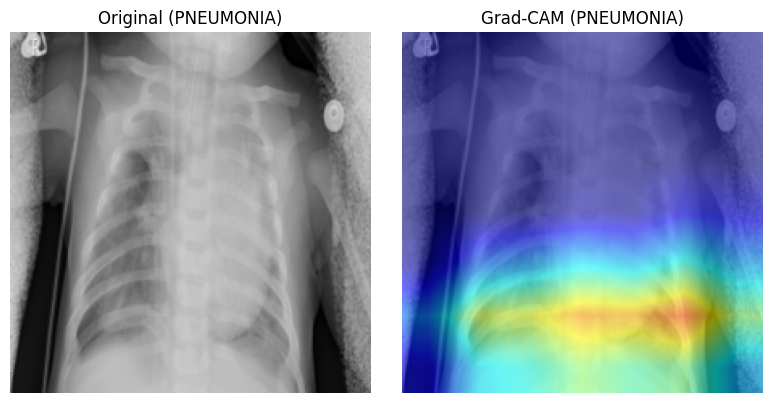

2025-11-25 09:43:50 [INFO] (712128529.py:34) - [4/6] Grad-CAM 시각화 중: Class PNEUMONIA


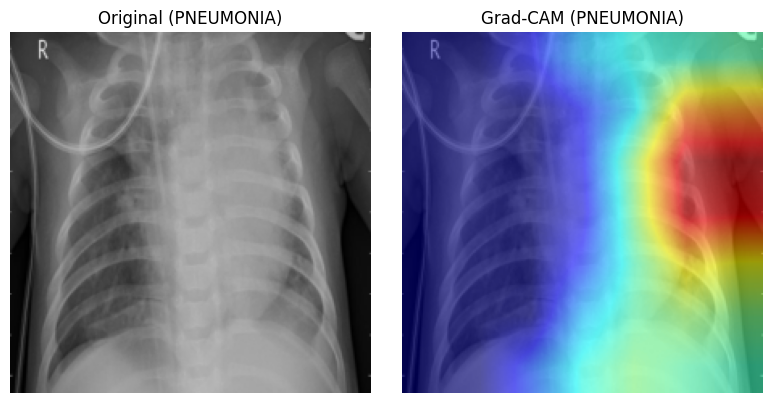

2025-11-25 09:43:56 [INFO] (712128529.py:34) - [5/6] Grad-CAM 시각화 중: Class PNEUMONIA


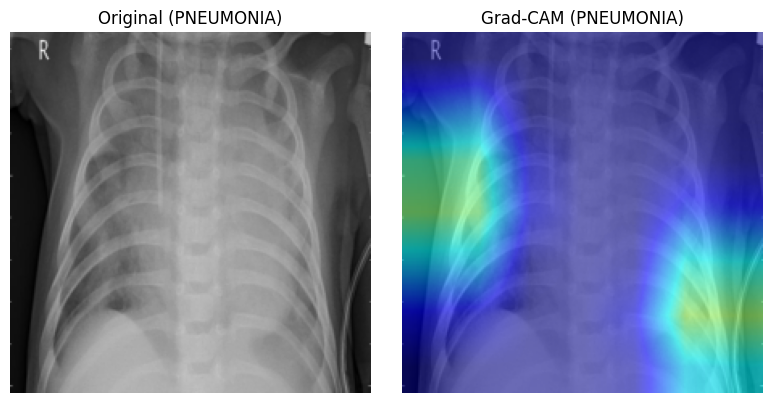

2025-11-25 09:44:08 [INFO] (712128529.py:34) - [6/6] Grad-CAM 시각화 중: Class PNEUMONIA


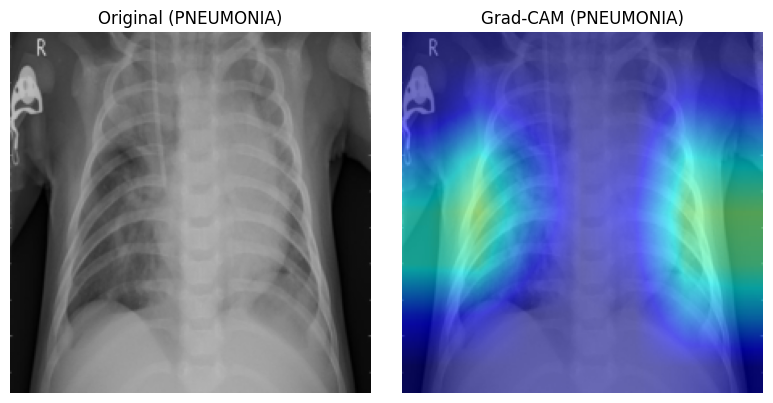

In [36]:
# ==================================================================
# Grad-CAM을 적용할 폐렴(PNEUMONIA) 샘플 여러 장 시각화
# 테스트 데이터 로더에서 PNEUMONIA 이미지만 N개 추출
# ==================================================================

# 1) Grad-CAM 타겟 레이어 설정 (ResNet18 Full FT)
target_layer = full_ft_model_for_cam.layer4[-1]
logger.info(f"Grad-CAM 타겟 레이어: {target_layer}")

# 2) PNEUMONIA 샘플 여러 장 수집
N_PNEUMONIA_SAMPLES = 6   # 원하는 개수로 조정 (예: 4, 8, 10 ...)

pneumo_images = []
pneumo_labels = []

for inputs, labels in test_loader:
    for i in range(inputs.size(0)):
        if labels[i].item() == 1:  # 1 == PNEUMONIA
            pneumo_images.append(inputs[i].unsqueeze(0).to(device))  # [1, C, H, W]
            pneumo_labels.append(labels[i].item())

            if len(pneumo_images) >= N_PNEUMONIA_SAMPLES:
                break
    if len(pneumo_images) >= N_PNEUMONIA_SAMPLES:
        break

if not pneumo_images:
    logger.error("테스트 데이터에서 PNEUMONIA 샘플을 찾을 수 없습니다.")
else:
    logger.info(f"PNEUMONIA 샘플 {len(pneumo_images)}개 추출 완료.")

    # 3) 추출된 각 폐렴 샘플에 대해 Grad-CAM 시각화
    for idx, (img_tensor, label) in enumerate(zip(pneumo_images, pneumo_labels), start=1):
        logger.info(f"[{idx}/{len(pneumo_images)}] Grad-CAM 시각화 중: Class {class_names[label]}")
        visualize_grad_cam(
            model=full_ft_model_for_cam,
            target_layer=target_layer,
            input_tensor=img_tensor,
            target_category=label,
            class_names=class_names,
        )

- 폐렴은 위치가 일정하지 않고, 모델도 병변에 따라 다양한 위치를 파악하고 있는 것으로 보임
- 특정 한 패턴을 암기한 것이 아닌 건강한 학습 패턴을 보이고 있음

## 7. test 예측 및 결과 분석

In [ ]:
# 1) 설정: 체크포인트 파일 지정 (원하면 파일명 바꿔서 실행)
ckpt_dir = Path("./x_ray_checkpoints")
print("Available checkpoints:", sorted([p.name for p in ckpt_dir.glob("*.pth")]))

# 기본: resnet18_full_best.pth
checkpoint_path = ckpt_dir / "resnet18_full_best.pth"


Available checkpoints: ['baseline_simplecnn_best.pth', 'baseline_simplecnn_last.pth', 'resnet18_frozen_best.pth', 'resnet18_frozen_last.pth', 'resnet18_full_best.pth', 'resnet18_full_last.pth', 'resnet18_partial_best.pth', 'resnet18_partial_last.pth']


In [38]:

# 2) 안전 체크: 필수 객체 존재 확인
try:
    _ = device
    _ = test_loader
    _ = class_names
except NameError as e:
    raise RuntimeError("이 셀을 실행하기 전에 `device`, `test_loader`, `class_names`가 정의된 이전 셀을 먼저 실행하세요.") from e

num_classes = len(class_names)


In [39]:
# 3) 모델 생성 및 체크포인트 로드
# 노트북에 이미 create_resnet18이 정의되어 있다면 그대로 사용하고, 없으면 자동으로 import fallback 사용
try:
    model = create_resnet18(num_classes=num_classes, mode="full")
except NameError:
    from torchvision import models
    import torch.nn as nn

    def create_resnet18(num_classes: int, mode: str = "full"):
        try:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            m = models.resnet18(weights=weights)
        except Exception:
            m = models.resnet18(pretrained=True)
        in_features = m.fc.in_features
        m.fc = nn.Linear(in_features, num_classes)
        return m

    model = create_resnet18(num_classes=num_classes, mode="full")

model.to(device)

if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}. 확인 후 경로를 수정하세요.")

ckpt = torch.load(str(checkpoint_path), map_location=device)
if isinstance(ckpt, dict) and "model_state" in ckpt:
    model.load_state_dict(ckpt["model_state"])
else:
    # 지원: checkpoint가 state_dict 또는 dict 형태일 수 있음
    try:
        model.load_state_dict(ckpt)
    except Exception:
        # 일부 체크포인트는 {'epoch':..., 'model_state':...} 등 포맷이 다름
        # 가장 일반적인 키 검색 시도
        for k in ("state_dict", "model_state_dict", "model_state"):
            if isinstance(ckpt, dict) and k in ckpt:
                model.load_state_dict(ckpt[k])
                break
        else:
            raise

model.eval()
print(f"Loaded model from: {checkpoint_path}")


Loaded model from: x_ray_checkpoints/resnet18_full_best.pth


In [ ]:
# 4) 실행: 실제 평가
results = evaluate_metrics(model, test_loader, device, logger=logger)


2025-11-25 10:37:09 [INFO] (3723731357.py:28) - Start evaluation on dataloader
2025-11-25 10:38:12 [INFO] (3723731357.py:51) - Eval result - acc: 0.9135, precision: 0.8925, recall: 0.9795, f1: 0.9340


Test results:
 Accuracy: 0.9135
 Precision: 0.8925
 Recall: 0.9795
 F1: 0.9340
Saved summary CSV to: eval_results/summary_resnet18_full_best.csv


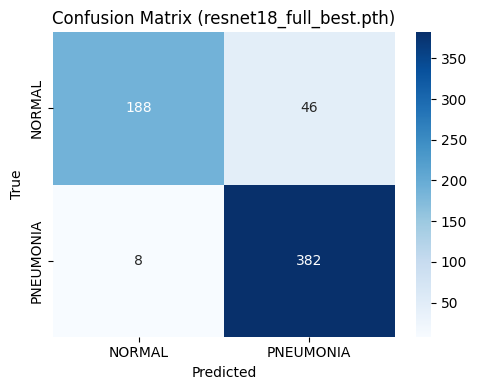

Saved confusion matrix image to: eval_results/confusion_matrix_resnet18_full_best.png
Saved predictions to: eval_results


In [ ]:
# 5) 출력 및 저장
print("Test results:")
print(f" Accuracy: {results['accuracy']:.4f}")
print(f" Precision: {results['precision']:.4f}")
print(f" Recall: {results['recall']:.4f}")
print(f" F1: {results['f1']:.4f}")

out_dir = Path("./eval_results")
out_dir.mkdir(exist_ok=True, parents=True)

# summary csv
df = pd.DataFrame([{
    "checkpoint": str(checkpoint_path.name),
    "accuracy": results["accuracy"],
    "precision": results["precision"],
    "recall": results["recall"],
    "f1": results["f1"],

}])
df.to_csv(out_dir / f"summary_{checkpoint_path.stem}.csv", index=False)
print("Saved summary CSV to:", out_dir / f"summary_{checkpoint_path.stem}.csv")

# confusion matrix 시각화
cm = results["confusion_matrix"]
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix ({checkpoint_path.name})")
plt.tight_layout()
img_path = out_dir / f"confusion_matrix_{checkpoint_path.stem}.png"
plt.savefig(img_path)
plt.show()
print("Saved confusion matrix image to:", img_path)

# predictions 저장
np.save(out_dir / f"y_true_{checkpoint_path.stem}.npy", results["y_true"])
np.save(out_dir / f"y_pred_{checkpoint_path.stem}.npy", results["y_pred"])
print("Saved predictions to:", out_dir)

> 정상을 맞게 분류한 케이스 : 188 건   
> 폐렴을 맞게 분류한 케이스 : 382 건   


> 정상을 폐렴으로 잘못 분류한 케이스 : 46 건   
> 폐렴을 정상으로 잘못 분류한 케이스 : 8 건

모델은 ‘폐렴을 놓치지 않음(높은 Recall)’을 우선으로 잘 학습되어 있으나,  
정상 이미지를 폐렴으로 잘못 판정하는 경우는 아직 여전히 의미있는 수치를 보여 Precision을 조금 더 개선할 여지가 있음

### 회고

1. 모델에 대한 이해도는 조금 올랐는데, 아직 모델과 평가함수의 유기적인 코드 구성은 헷갈린다...
2. 로거 써보긴 했는데 코드 복잡도가 올라가고, 통제가 좀 떨어진 듯 (ERROR 기능 안쓰고 로거 쓴 부분들도 있는 것 같기도..)
3. 코랩으로 돌렸었는데 런타임 제한이 맥북 로컬의 느린속도보다 더 치명적이었다. 체크포인트 같은 걸로 코드 수정은 했지만 그래도 여전히..(체크포인트 저장 불러오기가 계정별로 다른 드라이브 경로에 저장되기도 했고..) -> 결국 로컬로 마무리했다.
4. 이번에 코랩 에이전트 모드도 활용해봤는데 나름 편했고, ipynb 내에서만 실행하며 수정하는 점은 vscode 에이전트 모드와 차별점인듯
5. Grad-cam 시도해봤는데, 코드도 해석도 난이도가 좀 있었음
